In [75]:
import networkx as nx

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [76]:
df_original = pd.read_csv('data/primaryschool.csv', header=None, delimiter='\t', names = ['time', 'u', 'v', 'grade_u', 'grade_v'])
print(df_original.head())

metadata = pd.read_csv('data/metadata.txt', header=None, delimiter='\t', names = ['id', 'grade', 'gender'])
print(metadata.head())

    time     u     v grade_u grade_v
0  31220  1558  1567      3B      3B
1  31220  1560  1570      3B      3B
2  31220  1567  1574      3B      3B
3  31220  1632  1818      4B      4B
4  31220  1632  1866      4B      4B
     id grade gender
0  1426    5B      M
1  1427    5B      F
2  1428    5B      M
3  1429    5B      F
4  1430    5B      M


In [77]:
for _, row in df_original.iterrows():
    if row['u'] > row['v']:
        print(row)
        break

In [78]:
# Sort dataframe by source, target, and timestamp
df_original = df_original.sort_values(by=['u', 'v', 'time'])

# Initialize an empty list to store the results
df = []

# Iterate through the dataframe to calculate weights
for (u, v), group in df_original.groupby(['u', 'v']):
    timestamps = group['time'].tolist()
    weight = 1
    first_time = timestamps[0]
    for i in range(1, len(timestamps)):
        if timestamps[i] == timestamps[i-1] + 20:
            weight += 1
        else:
            df.append({'u': u, 'v': v, 'weight': weight, 'time': first_time})
            weight = 1
            first_time = timestamps[i]
    df.append({'u': u, 'v': v, 'weight': weight, 'time': first_time})

# Create a new dataframe from the result
df = pd.DataFrame(df)

print(df.head(10))

      u     v  weight   time
0  1426  1427       1  36740
1  1426  1427       2  36940
2  1426  1427       2  39640
3  1426  1427       2  52820
4  1426  1427       1  54760
5  1426  1427       2  56580
6  1426  1427       1  60680
7  1426  1427       2  61080
8  1426  1427       1  61160
9  1426  1427       2  61320


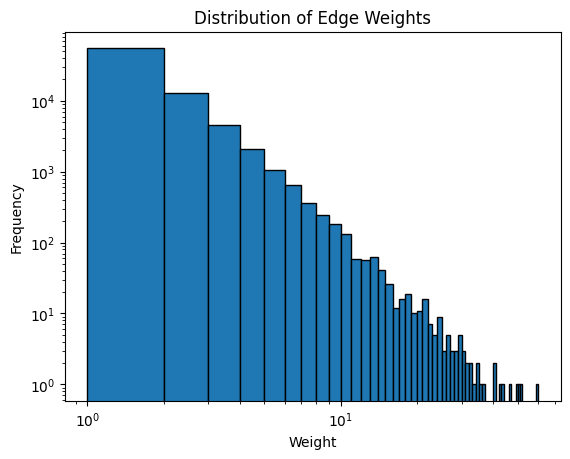

In [79]:
# Plot the distribution of weights
plt.hist(df['weight'], bins=range(1, df['weight'].max() + 2), edgecolor='black')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.title('Distribution of Edge Weights')
plt.show()

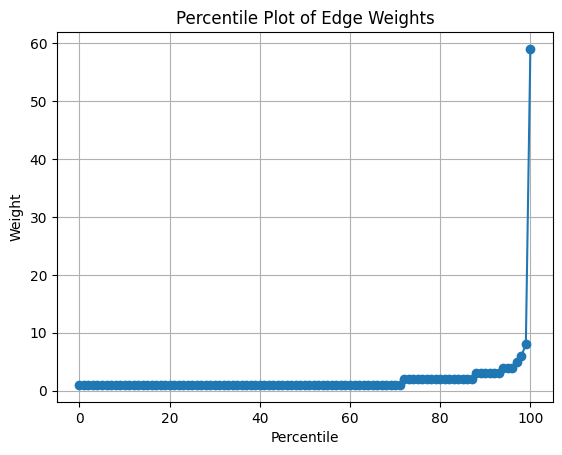

percentile value: 3.0


In [ ]:
percentiles = np.percentile(df['weight'], np.arange(0, 101, 1))

# Plot the percentiles
plt.plot(np.arange(0, 101, 1), percentiles, marker='o')
plt.xlabel('Percentile')
plt.ylabel('Weight')
plt.title('Percentile Plot of Edge Weights')
plt.grid(True)
plt.show()

print("50th percentile value:", percentiles[50])

# Let's use 60sec as our threashold for an edge to be valid.

In [81]:
thr = 5

In [82]:
df = df[df['weight'] >= thr]

do all the plotting as usual.

# Plotting communities

In [83]:
grade_dict = {"1A": "red", "1B": "red", "2A": "orange", "2B": "orange", "3A": "gray", "3B": "gray", "4A": "cyan", "4B": "cyan", "5A": "blue", "5B": "blue", "Teachers": "black"}
grade_dict_more = {"1A": "firebrick", "1B": "red", "2A": "orange", "2B": "sandybrown", "3A": "slategray", "3B": "gray", "4A": "darkturquoise", "4B": "cyan", "5A": "cornflowerblue", "5B": "blue", "Teachers": "black"}

node_grade = {}
for _, row in metadata.iterrows():
    node_grade[row['id']] = row['grade']

In [84]:
G = nx.Graph()
for _, row in metadata.iterrows():
    if row['grade'] != "Teachers":
        G.add_node(row['id'], color=grade_dict_more[row['grade']])

for _, edge in df.iterrows():
    if node_grade[edge['u']] != "Teachers" and node_grade[edge['v']] != "Teachers":
        G.add_edge(edge['u'], edge['v'], weight=edge['weight'])


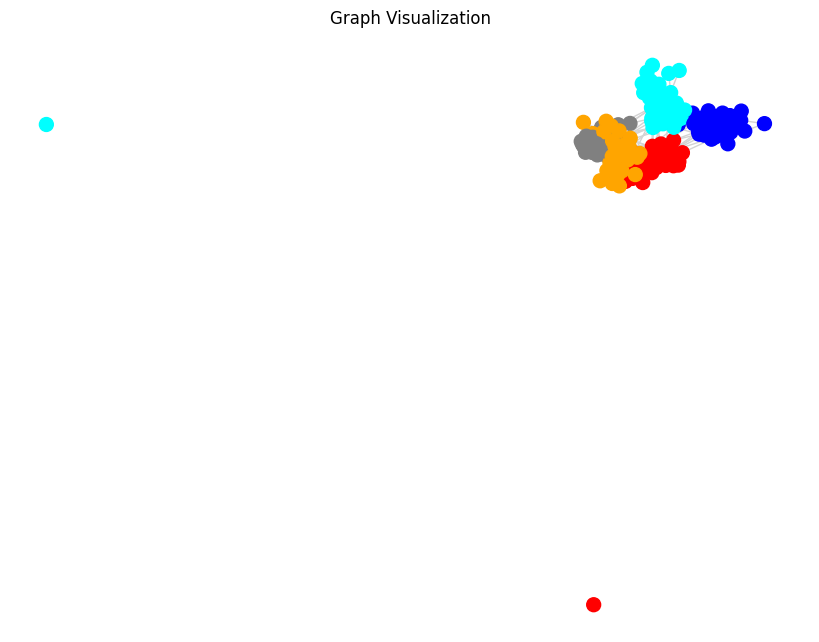

In [85]:
# Draw the graph
node_colors = [grade_dict[node_grade[node]] for node in G.nodes()]

plt.figure(figsize=(8, 6))
nx.draw(G, node_size=100, node_color = node_colors, edge_color='lightgray')
plt.title("Graph Visualization")
plt.show()

In [86]:
G.number_of_edges()

991

## Louvian Method

* Compute the partition of the graph nodes which maximises the modularity (or try..) using the Louvain heuristices
* Param: resolution:double, optional - Will change the size of the communities, default to 1. represents the time described in “Laplacian Dynamics and Multiscale Modular Structure in Networks”, R. Lambiotte, J.-C. Delvenne, M. Barahona

In [87]:
# Run community detection to find two components
from networkx.algorithms import community

# Use a community detection algorithm (e.g., Girvan-Newman method)
communities = list(community.girvan_newman(G))


In [88]:
len(communities[0])

4

### Note
draw_graph_per_community(G, pos, node_colors, communities[2]) divides them into their grades -- this means there wont be any community mmixing later on in ths algorithm -- becuase of its iterative nature.

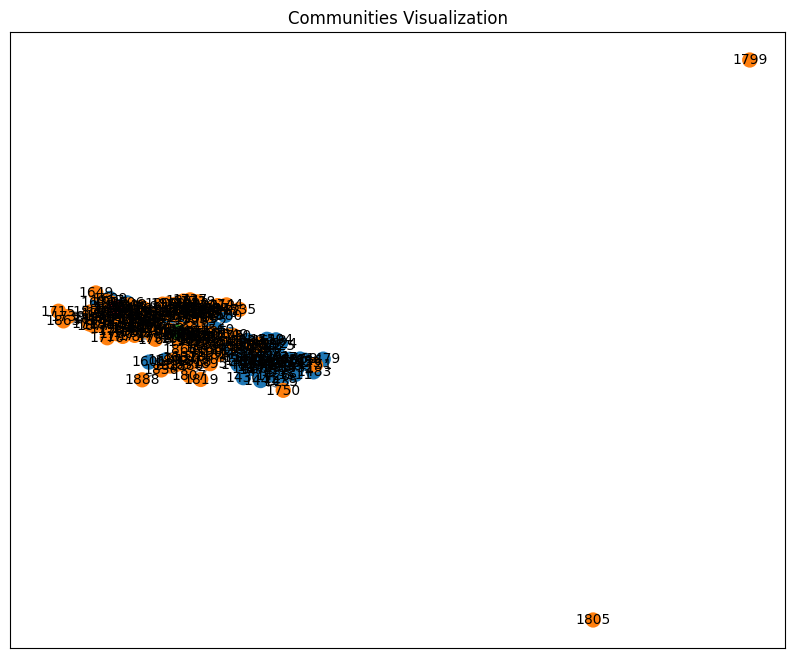

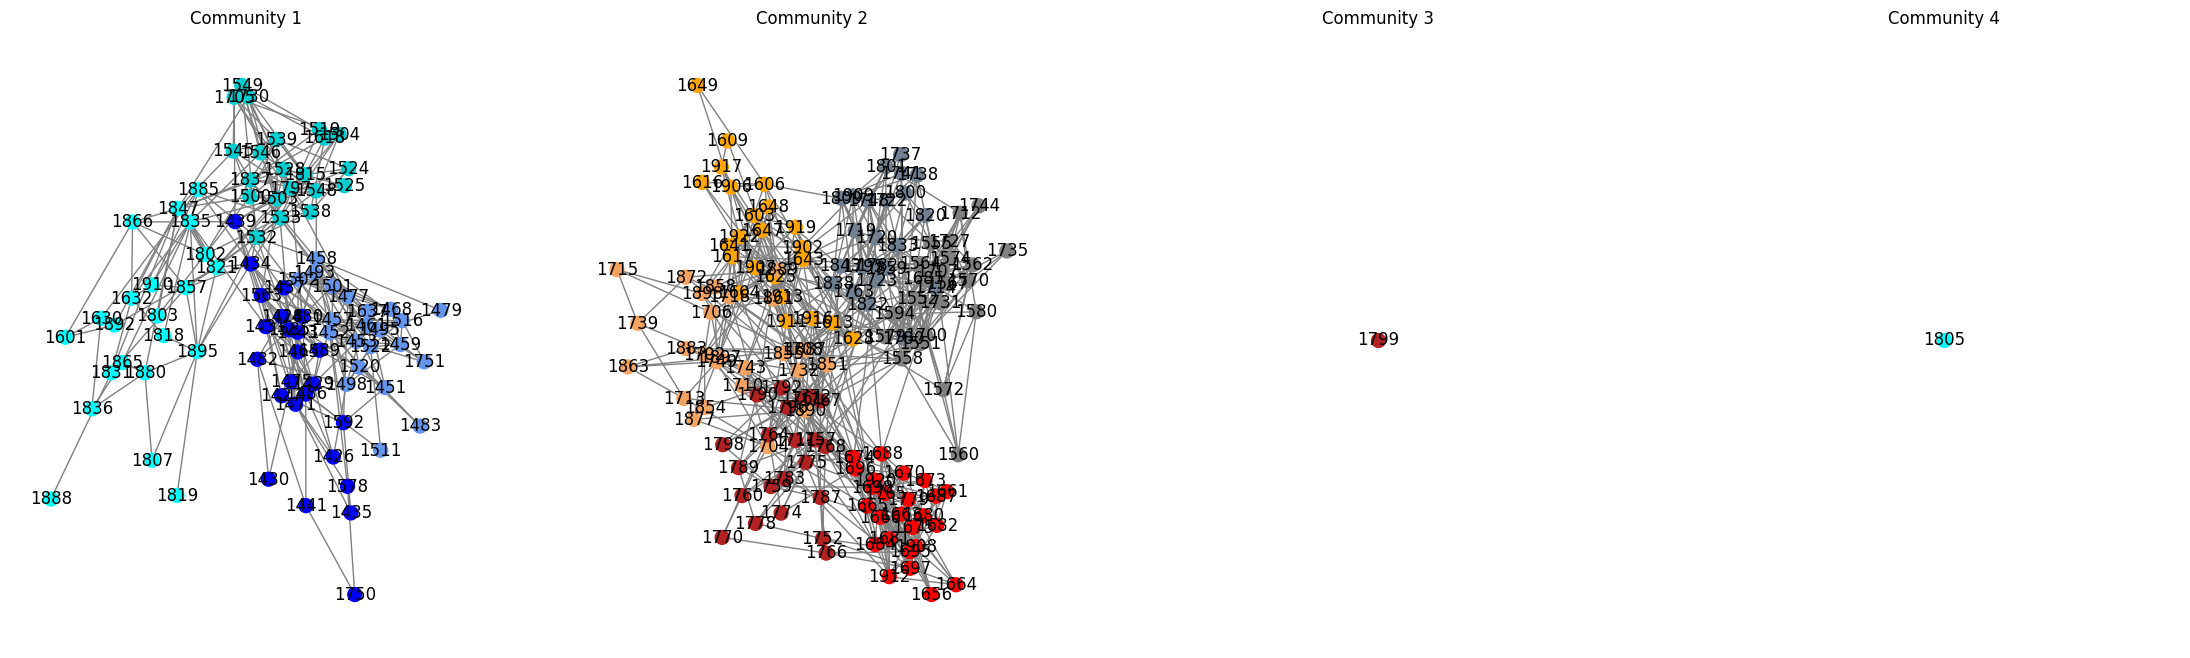

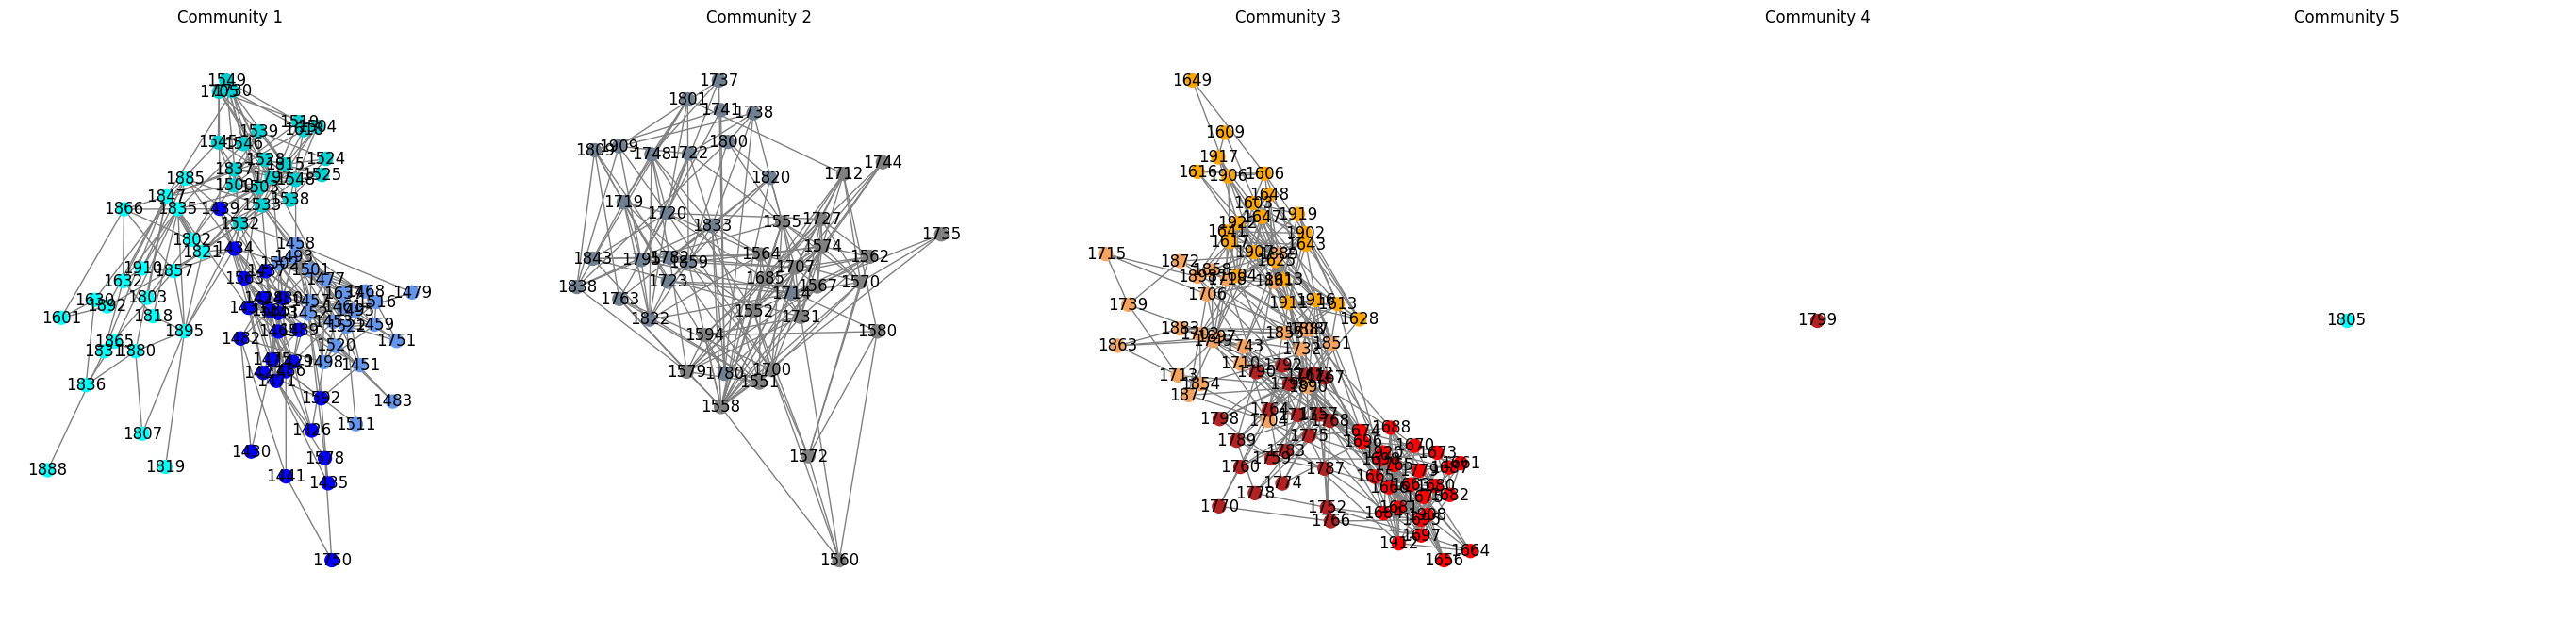

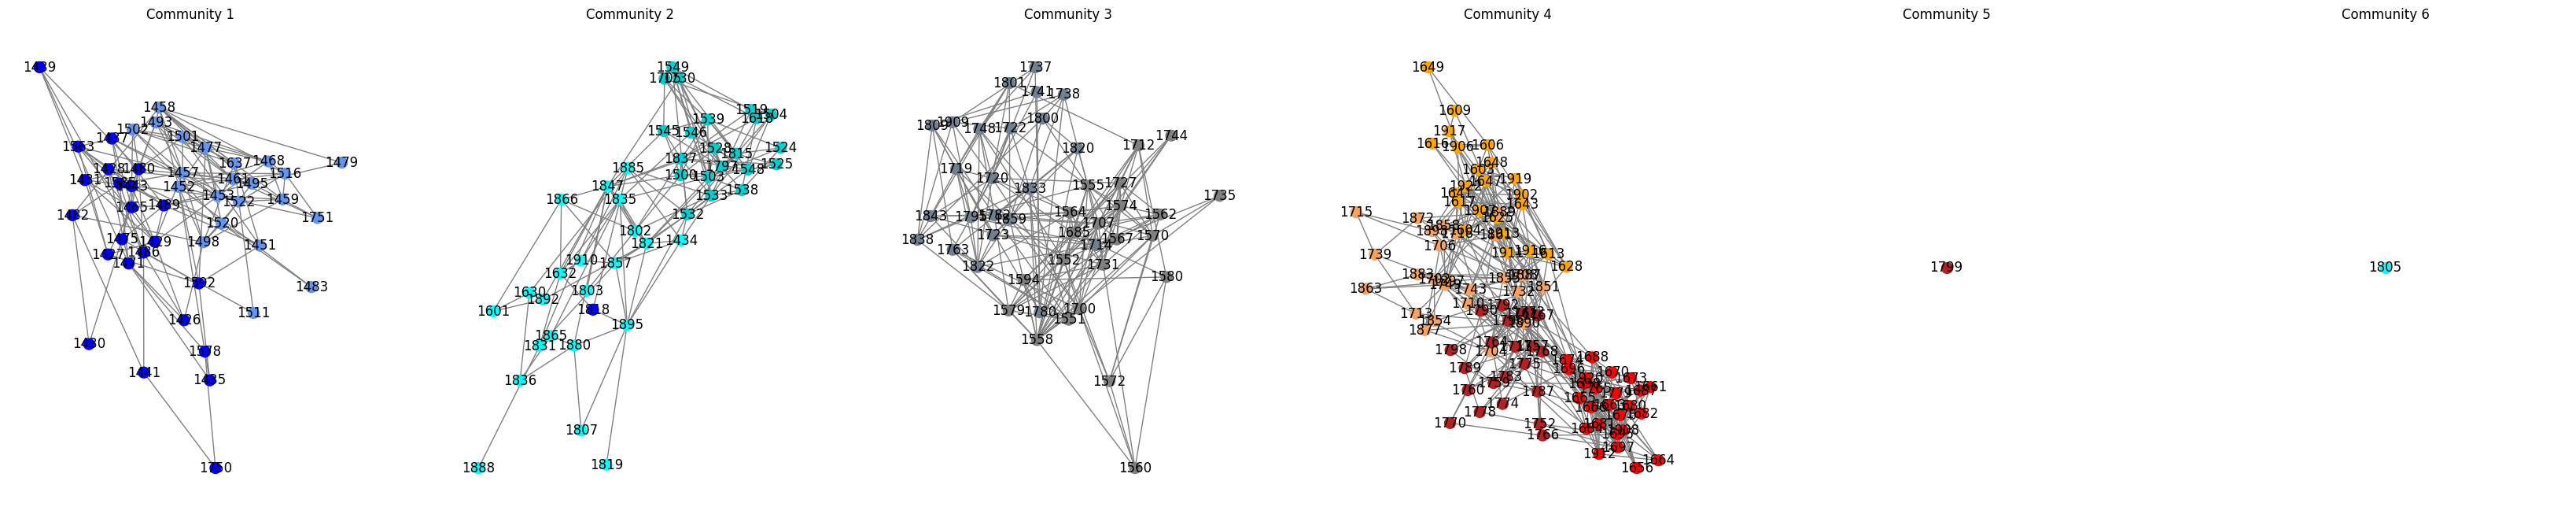

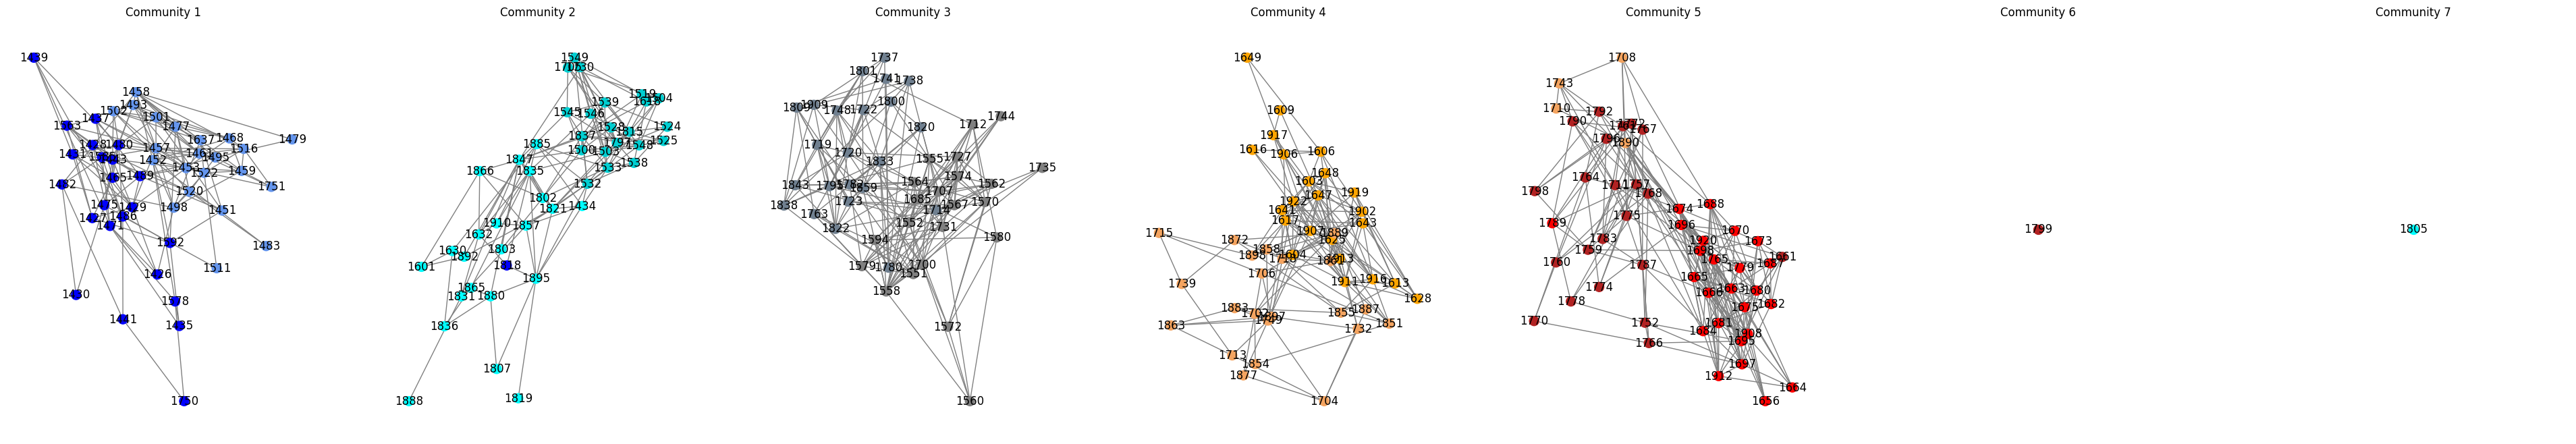

In [89]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import cycle, islice

# Assign colors to each community
def assign_colors_to_communities(G, communities):
    pos = nx.spring_layout(G)  # Layout for visualization
    color_cycle = cycle(plt.cm.tab10.colors)  # Color palette
    node_colors = {}

    for i, community in enumerate(communities[0]):  # Consider the first level of communities
        color = next(color_cycle)
        for node in community:
            node_colors[node] = color

    return pos, node_colors

# Draw the graph
def draw_graph_with_communities(G, pos, node_colors):
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_color=list(node_colors.values()), cmap=plt.cm.tab10, node_size=100)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color="black")
    plt.title("Communities Visualization")
    plt.show()

def draw_graph_per_community(G, pos, node_colors, communities):
    fig, axes = plt.subplots(1, len(communities), figsize=(7*len(communities), 8))
    if len(communities) == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, community in zip(axes, communities):
        subgraph = G.subgraph(community)
        nx.draw(subgraph, pos, ax=ax, node_color=[grade_dict_more[node_grade[node]]  for node in community], with_labels=True, node_size=100, edge_color='gray')
        ax.set_title(f"Community {communities.index(community) + 1}")

    plt.show()

# Assign positions and colors
pos, node_colors = assign_colors_to_communities(G, communities)

# Visualize the graph
draw_graph_with_communities(G, pos, node_colors)
draw_graph_per_community(G, pos, node_colors, communities[0])

draw_graph_per_community(G, pos, node_colors, communities[1])

draw_graph_per_community(G, pos, node_colors, communities[2])

draw_graph_per_community(G, pos, node_colors, communities[3])

# draw_graph_per_community(G, pos, node_colors, communities[4])

# draw_graph_per_community(G, pos, node_colors, communities[10])


## Label Propagation

Number of communities detected: 6


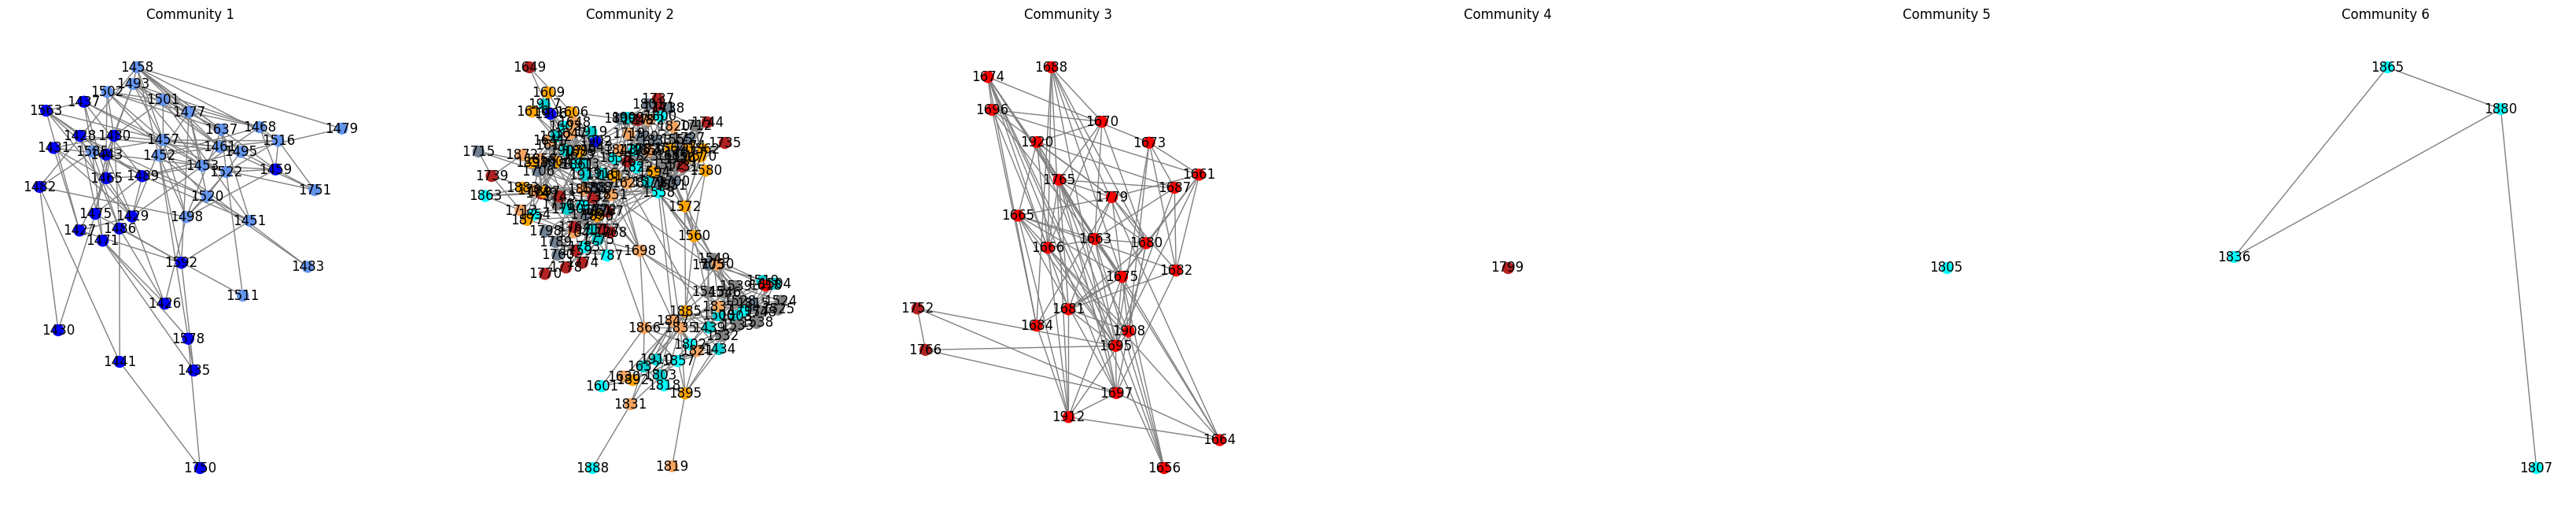

In [90]:
from networkx.algorithms.community import label_propagation_communities

# Detect communities
communities = list(label_propagation_communities(G))

# Visualize
print(f"Number of communities detected: {len(communities)}")

draw_graph_per_community(G, pos, node_colors, communities)

## Spectral Clustering

In [91]:
from sklearn.cluster import SpectralClustering
import numpy as np

adj_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix
n_clusters = 10  # Define the number of clusters

clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=42)
labels = clustering.fit_predict(adj_matrix)

# Group nodes into communities
from collections import defaultdict
communities = defaultdict(list)
for node, label in zip(G.nodes, labels):
    communities[label].append(node)

print(f"Number of communities detected: {len(communities)}")


Number of communities detected: 10


c:\Users\Dell 5520\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:50: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  connected_nodes = np.zeros(n_node, dtype=np.bool)
c:\Users\Dell 5520\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:51: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  nodes_to_explore = np.zero

Number of communities detected: 10


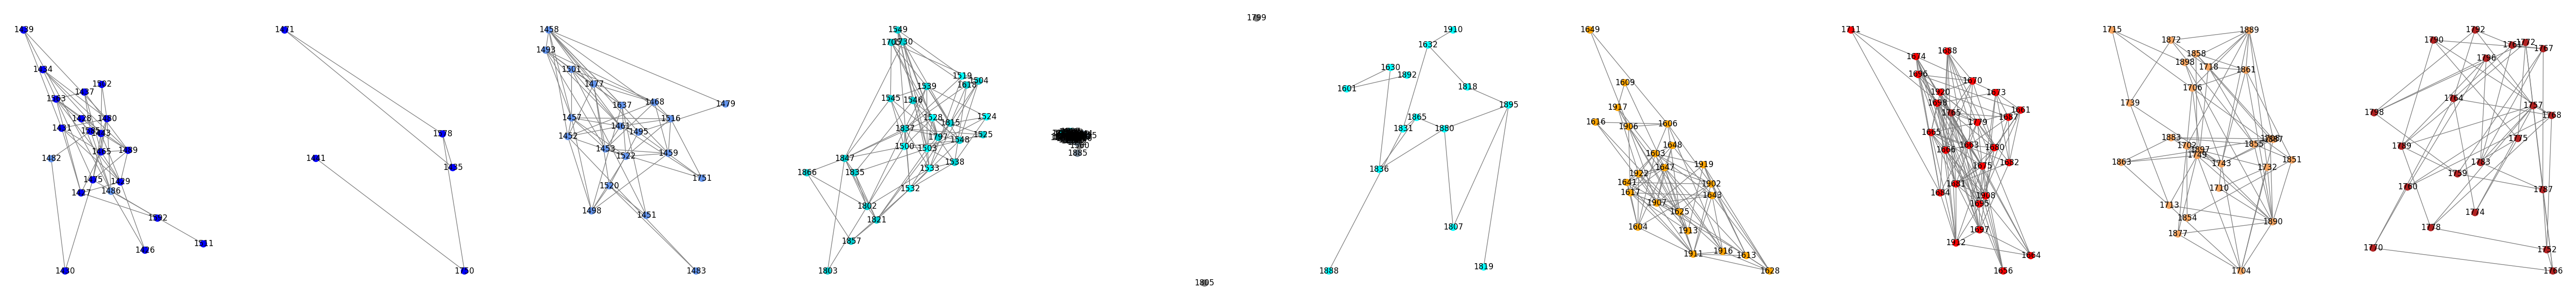

In [92]:
print(f"Number of communities detected: {len(communities)}")

def draw_graph_per_community(G, pos, node_colors, communities):
    fig, axes = plt.subplots(1, len(communities), figsize=(7*len(communities), 8))
    if len(communities) == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, community in zip(axes, communities):
        subgraph = G.subgraph(community)
        nx.draw(subgraph, pos, ax=ax, node_color=[grade_dict_more[node_grade[node]]  for node in community], with_labels=True, node_size=100, edge_color='gray')
        #ax.set_title(f"Community {communities.index(community) + 1}")

    plt.show()

draw_graph_per_community(G, pos, node_colors, communities.values())